In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import models
from keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import regularizers

In [2]:
from google.colab import files
uploaded=files.upload()

Saving CarPrice_Assignment.csv to CarPrice_Assignment (13).csv


In [3]:
import io
df=pd.read_csv(io.BytesIO(uploaded["CarPrice_Assignment.csv"]))

In [4]:
df.info()
df.size
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

(205, 26)

In [5]:
df[df.duplicated()]

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price


In [6]:
normalized_data=df.copy()

In [7]:
normalized_data.iloc[3,2]="audi 100ls"
normalized_data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


**One Hot Encoding**

In [8]:
# Since 10 coulmns are object types so we have to encode and concatenate them 
#all = pd.get_dummies(normalized_data, columns=["fueltype", "aspiration", "doornumber", "carbody","drivewheel", "enginelocation","enginetype", "cylindernumber"]).astype(dtype="float64")

#column2= pd.get_dummies(normalized_data.iloc[:, 2:3]).astype(dtype="float64")
column3= pd.get_dummies(normalized_data.iloc[:, 3:4]).astype(dtype="float64")
column4= pd.get_dummies(normalized_data.iloc[:, 4:5]).astype(dtype="float64")
column5= pd.get_dummies(normalized_data.iloc[:, 5:6]).astype(dtype="float64")
column6= pd.get_dummies(normalized_data.iloc[:, 6:7]).astype(dtype="float64")
column7= pd.get_dummies(normalized_data.iloc[:, 7:8]).astype(dtype="float64")
column8= pd.get_dummies(normalized_data.iloc[:, 8:9]).astype(dtype="float64")
column14= pd.get_dummies(normalized_data.iloc[:, 14:15]).astype(dtype="float64")
column15= pd.get_dummies(normalized_data.iloc[:, 15:16]).astype(dtype="float64")
column17= pd.get_dummies(normalized_data.iloc[:, 17:18]).astype(dtype="float64")


In [9]:
#Deleting the original columns
normalized_data.drop(columns=["CarName", "fueltype", "aspiration", "doornumber", "carbody","drivewheel", "enginelocation", "enginetype", "cylindernumber", "fuelsystem"], axis=1, inplace=True)
normalized_data.drop(columns=["car_ID"], axis=1, inplace=True)

**Normalizing the data**

In [10]:
max=normalized_data.max()
min=normalized_data.min()
normalized_data=(normalized_data-min)/(max-min)

normalized_data=normalized_data.iloc[:,:-1]

x_labels=normalized_data.iloc[:,-1:]

normalized_data.shape

(205, 14)

In [11]:
x_data =pd.concat([ column3, column4, column5, column6, column7, column8, column14, column15, column17, normalized_data], axis=1)

**Split Training and Testing data**

In [12]:
train_data, test_data, train_labels, test_labels=train_test_split(x_data, x_labels, test_size=0.3, random_state=1)

In [15]:
train_labels=np.asarray(train_labels).astype(dtype="float64")
test_labels=np.asarray(test_labels).astype(dtype="float64")

**Building the Network**

In [16]:
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(32, kernel_regularizer=regularizers.l1( l1=0.001), activation = "relu", input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(10,kernel_regularizer=regularizers.l1( l1=0.001), activation="relu"))
  model.add(layers.Dense(8,kernel_regularizer=regularizers.l1( l1=0.001), activation="relu"))
  model.add(layers.Dense(6,kernel_regularizer=regularizers.l1( l1=0.001), activation="relu"))
  model.add(layers.Dense(1))
  model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
  return model


**K fold validation**

In [17]:
k= 4
num_val_sample = len(train_data) // k
num_epochs = 100
all_scores = []
all_val_loss_histories = []
all_val_mae_histories = []
all_loss_histories =[]
all_mae_histories = []

for i in range(k):
  print("processing fold #",i)
  val_data = train_data[i*num_val_sample:(i+1)*num_val_sample]
  val_labels = train_labels[i*num_val_sample: (i+1)*num_val_sample]

  partial_train_data=np.concatenate([train_data[:i*num_val_sample], train_data[(i+1)*num_val_sample:]], axis=0)
  partial_train_labels=np.concatenate([train_labels[:i*num_val_sample], train_labels[(i+1)*num_val_sample:]], axis=0)

  model=build_model()
  history = model.fit(partial_train_data, partial_train_labels, validation_data = (val_data, val_labels), epochs= num_epochs, batch_size=1, verbose=0)
  val_loss, val_mae = model.evaluate(test_data, test_labels, verbose=0)
  val_loss_history = history.history["val_loss"]
  val_mae_history = history.history["val_mae"]
  loss_history = history.history["loss"]
  mae_history = history.history["mae"]
  all_loss_histories.append(loss_history)
  all_mae_histories.append(mae_history)
  all_val_loss_histories.append(val_loss_history)
  all_val_mae_histories.append(val_mae_history)
  all_scores.append(val_mae)
ave_val_loss_hist = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
ave_loss_hist = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
ave_val_mae_hist = [np.mean([x[i] for x in all_val_mae_histories]) for i in range(num_epochs)]
ave_mae_hist = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
all_scores

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


[0.01410262007266283,
 0.020142797380685806,
 0.017207050696015358,
 0.01072081457823515]

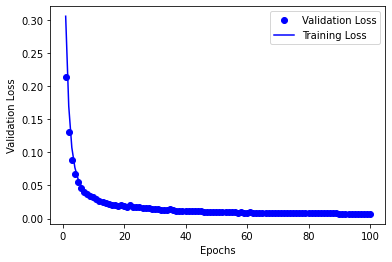

In [29]:
plt.plot(range(1, len(ave_val_loss_hist)+1)[:], ave_val_loss_hist[:], "bo", label="Validation Loss")
plt.plot(range(1, len(ave_val_loss_hist)+1)[:], ave_loss_hist[:], "b", label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

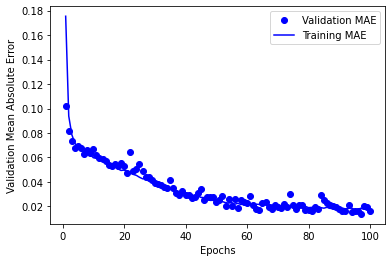

In [30]:
plt.plot(range(1, len(ave_val_mae_hist)+1)[:], ave_val_mae_hist[:], "bo", label="Validation MAE")
plt.plot(range(1, len(ave_val_mae_hist)+1)[:], ave_mae_hist[:], "b", label="Training MAE")
plt.xlabel("Epochs")
plt.ylabel("Validation Mean Absolute Error")
plt.legend()
plt.show()

**Building the best fit Model**

In [20]:
model = models.Sequential()
model.add(layers.Dense(32, kernel_regularizer=regularizers.l1( l1=0.001), activation = "relu", input_shape=(train_data.shape[1],)))
model.add(layers.Dense(10,kernel_regularizer=regularizers.l1( l1=0.001), activation="relu"))
model.add(layers.Dense(8,kernel_regularizer=regularizers.l1( l1=0.001), activation="relu"))
model.add(layers.Dense(6,kernel_regularizer=regularizers.l1( l1=0.001), activation="relu"))
model.add(layers.Dense(1))
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

**Training the model with all samples**

In [21]:
model.fit(train_data, train_labels, epochs=100)

Epoch 1/100
5/5 [==============================] - 1s 4ms/step - loss: 0.3778 - mae: 0.1881
Epoch 2/100
5/5 [==============================] - 0s 2ms/step - loss: 0.3292 - mae: 0.1023
Epoch 3/100
5/5 [==============================] - 0s 3ms/step - loss: 0.3165 - mae: 0.0905
Epoch 4/100
5/5 [==============================] - 0s 2ms/step - loss: 0.3067 - mae: 0.0772
Epoch 5/100
5/5 [==============================] - 0s 3ms/step - loss: 0.3005 - mae: 0.0795
Epoch 6/100
5/5 [==============================] - 0s 2ms/step - loss: 0.2940 - mae: 0.0772
Epoch 7/100
5/5 [==============================] - 0s 2ms/step - loss: 0.2865 - mae: 0.0746
Epoch 8/100
5/5 [==============================] - 0s 3ms/step - loss: 0.2772 - mae: 0.0658
Epoch 9/100
5/5 [==============================] - 0s 2ms/step - loss: 0.2696 - mae: 0.0623
Epoch 10/100
5/5 [==============================] - 0s 3ms/step - loss: 0.2616 - mae: 0.0592
Epoch 11/100
5/5 [==============================] - 0s 3ms/step - loss: 0.2541 

**Evaluating the Network**

In [25]:
test_mse_scoe, test_mae_score=model.evaluate(test_data, test_labels)

2/2 [==============================] - 0s 3ms/step - loss: 0.0254 - mae: 0.0442


In [26]:
test_mae_score

0.044219009578228

**Predicting the values**

In [27]:
prediction=model.predict(test_data)

pred_norm=(prediction*(max[-1]-min[-1]))+min[-1]
test_norm = (test_labels*(max[-1]-min[-1]))+min[-1]

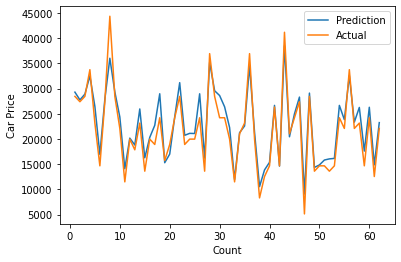

In [34]:
plt.plot(range(1, len(pred_norm[:])+1), pred_norm[:], label="Prediction")
plt.plot(range(1, len(pred_norm[:])+1), test_norm[:], label="Actual")
plt.xlabel("Count")
plt.ylabel("Car Price")
plt.legend()
plt.show()